# CLASSIFIER
Программа подбирает эмоцию по полученному текстовому сообщению

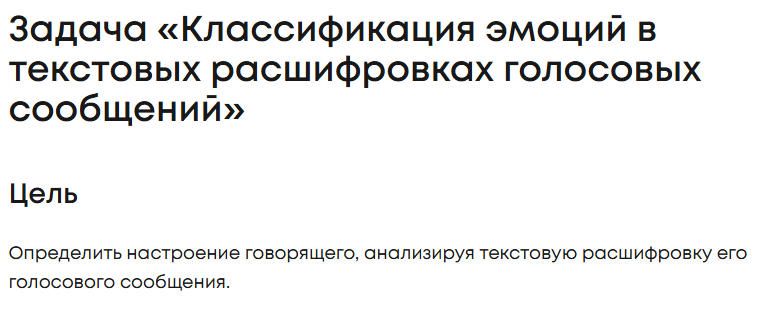

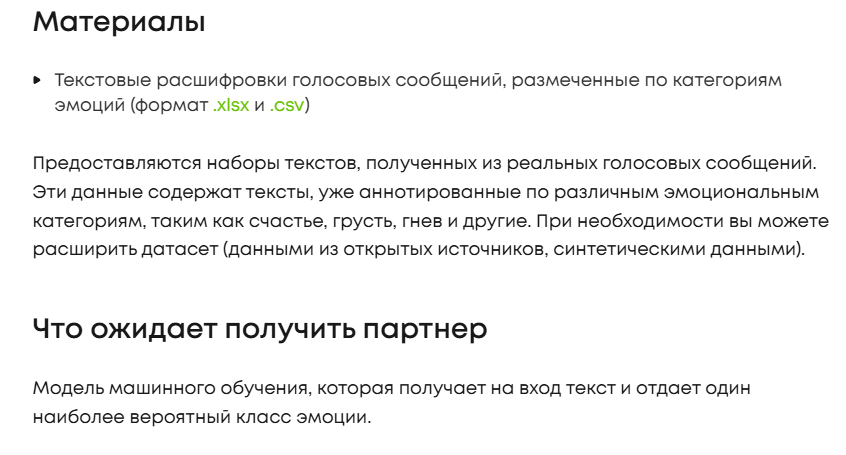

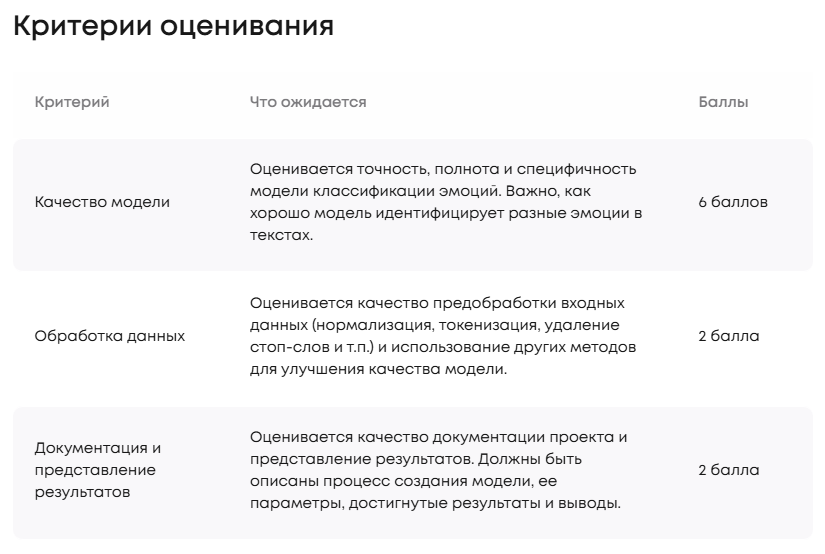

In [6]:
#!pip install --upgrade gensim
# !pip install spacy
# !python -m spacy download ru_core_news_sm

In [7]:
import numpy as np
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
import joblib
import pickle

In [8]:
RANDOM_STATE = 13

## EDA

    Для начала загрузим данные и посмотрим на них

In [9]:
df = pd.read_csv('data/asset-v1_FACTORY+FACTORY+2023+type@asset+block@Фразы-эмоции.csv')
df

,Текст фразы,Эмоция
0,"Я не могу поверить, что ты снова опоздал на ва...",Недовольство
1,"Врач, к которому меня направили, оказался груб...",Недовольство
2,Как же меня раздражает твоя привычка постоянно...,Недовольство
3,"Мне кажется, что некоторые врачи просто зараба...",Недовольство
4,Мне надоело слушать твои бесконечные жалобы и ...,Недовольство
...,...,...
1038,"Да, конечно, я вам помогу.",Нейтрально
1039,"Можете повторить ваш адрес, пожалуйста?",Нейтрально
1040,Я уточню эту информацию и вернусь к вам.,Нейтрально
1041,"Извините, я вас плохо слышу.",Нейтрально


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Текст фразы  1043 non-null   object
 1   Эмоция       1043 non-null   object
dtypes: object(2)
memory usage: 16.4+ KB


In [11]:
df.describe()

,Текст фразы,Эмоция
count,1043,1043
unique,1039,8
top,"Врач, к которому меня направили, оказался груб...",Нейтрально
freq,2,204


In [12]:
df['Текст фразы'].value_counts()

Текст фразы
Врач, к которому меня направили, оказался грубым и невнимательным человеком, который разговаривал со мной свысока, перебивал меня и не слушал мои жалобы. Он не объяснил мне, что со мной происходит, не рассказал о возможных методах лечения и даже не попытался успокоить меня.    2
Я просто в восторге от этой новости!                                                                                                                                                                                                                                                  2
Я очень рада, что вы нашли в себе силы обратиться ко мне.                                                                                                                                                                                                                             2
Невероятный день! Сделал столько всего интересного!                                                                                                 

In [13]:
df['Эмоция'].value_counts()

Эмоция
Нейтрально      204
Радость         163
Сочувствие      145
Злость          141
Печаль          133
Зависть         125
Интерес         117
Недовольство     15
Name: count, dtype: int64

    Так же посмотрим совпадают ли эмодзи у совпадающих текстов и если это так, то удалим дубли

In [14]:
text_vc = df['Текст фразы'].value_counts() 
mask = text_vc.values > 1
# получаю фразы, появляющиеся более одного раза
common_phrases = text_vc[mask]
mask = df['Текст фразы'].apply(lambda x: x in list(common_phrases.index))
df[mask]

,Текст фразы,Эмоция
1,"Врач, к которому меня направили, оказался груб...",Недовольство
7,"Врач, к которому меня направили, оказался груб...",Недовольство
309,"Я очень рада, что вы нашли в себе силы обратит...",Сочувствие
323,"Я очень рада, что вы нашли в себе силы обратит...",Сочувствие
477,Невероятный день! Сделал столько всего интерес...,Радость
480,Я просто в восторге от этой новости!,Радость
510,Невероятный день! Сделал столько всего интерес...,Радость
561,Я просто в восторге от этой новости!,Радость


    Видно, что строчки выше являются полными дублями. Их надо удалить.

In [15]:
crop_df = df.drop_duplicates()
print(f'В DataFrame осталось {crop_df.shape[0]} записей.')

В DataFrame осталось 1039 записей.


## FEATURE ENGINEERING

### Токинезирую фразу

In [16]:
nlp = spacy.load('ru_core_news_sm')

In [17]:
def ProProcessing(text:str):
    """Преобразует фразу в список из 91 токена"""
    doc = nlp(text)
    # print(f'После токинезации, получаю {doc.__len__()} токенов')
    # # Удаляю Стоп-слова
    filtered_tokens = [token for token in doc if not token.is_stop]
    # print(f'После удаления стоп-слов, получаю {filtered_tokens.__len__()} токенов.\n\tПРИМЕР токенов {filtered_tokens[:10]}')
    # # Привожу к нормальной форме
    filtered_tokens_lemma = np.unique([token.lemma_ for token in filtered_tokens])
    # print(f'После приведения тоекнов к lemma и удаления дублей, осталось {len(filtered_tokens_lemma)} токенов.\n\tПРИМЕР токенов {filtered_tokens_lemma[:20]}')
    return nlp(' '.join(filtered_tokens_lemma)).vector
    
crop_df['tokens'] = crop_df['Текст фразы'].apply(lambda x: ProProcessing(x))
crop_df

C:\Users\user2\AppData\Local\Temp\ipykernel_27808\2146856682.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crop_df['tokens'] = crop_df['Текст фразы'].apply(lambda x: ProProcessing(x))


,Текст фразы,Эмоция,tokens
0,"Я не могу поверить, что ты снова опоздал на ва...",Недовольство,"[0.61690074, 0.3898254, -0.14748453, 1.1789458..."
1,"Врач, к которому меня направили, оказался груб...",Недовольство,"[0.65575826, 0.44666058, 0.2989121, 0.12339903..."
2,Как же меня раздражает твоя привычка постоянно...,Недовольство,"[0.31221262, 0.16091426, 0.6718934, 0.16831265..."
3,"Мне кажется, что некоторые врачи просто зараба...",Недовольство,"[0.3149734, 0.245104, -0.035946243, 0.20341331..."
4,Мне надоело слушать твои бесконечные жалобы и ...,Недовольство,"[0.1828211, 0.21101302, -0.21804628, 0.2093698..."
...,...,...,...
1038,"Да, конечно, я вам помогу.",Нейтрально,"[-0.18198426, 0.15749489, -0.58592546, -0.3159..."
1039,"Можете повторить ваш адрес, пожалуйста?",Нейтрально,"[-0.080453366, 0.5769746, 0.4890749, -0.264467..."
1040,Я уточню эту информацию и вернусь к вам.,Нейтрально,"[-0.3958928, -0.08645894, -0.63752884, -0.7132..."
1041,"Извините, я вас плохо слышу.",Нейтрально,"[0.42459995, 0.33399382, 0.24732578, -0.304906..."


### Токинезирую таргет

In [18]:
# формирую словар эмоций
emotions_dict = {emotion: i for i, emotion in enumerate(crop_df['Эмоция'].unique())}
emotions_dict

{'Недовольство': 0,
 'Злость': 1,
 'Зависть': 2,
 'Сочувствие': 3,
 'Радость': 4,
 'Печаль': 5,
 'Интерес': 6,
 'Нейтрально': 7}

In [19]:
crop_df['emotion_key'] = crop_df['Эмоция'].apply(lambda x: emotions_dict[x])
crop_df

C:\Users\user2\AppData\Local\Temp\ipykernel_27808\2609341692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crop_df['emotion_key'] = crop_df['Эмоция'].apply(lambda x: emotions_dict[x])


,Текст фразы,Эмоция,tokens,emotion_key
0,"Я не могу поверить, что ты снова опоздал на ва...",Недовольство,"[0.61690074, 0.3898254, -0.14748453, 1.1789458...",0
1,"Врач, к которому меня направили, оказался груб...",Недовольство,"[0.65575826, 0.44666058, 0.2989121, 0.12339903...",0
2,Как же меня раздражает твоя привычка постоянно...,Недовольство,"[0.31221262, 0.16091426, 0.6718934, 0.16831265...",0
3,"Мне кажется, что некоторые врачи просто зараба...",Недовольство,"[0.3149734, 0.245104, -0.035946243, 0.20341331...",0
4,Мне надоело слушать твои бесконечные жалобы и ...,Недовольство,"[0.1828211, 0.21101302, -0.21804628, 0.2093698...",0
...,...,...,...,...
1038,"Да, конечно, я вам помогу.",Нейтрально,"[-0.18198426, 0.15749489, -0.58592546, -0.3159...",7
1039,"Можете повторить ваш адрес, пожалуйста?",Нейтрально,"[-0.080453366, 0.5769746, 0.4890749, -0.264467...",7
1040,Я уточню эту информацию и вернусь к вам.,Нейтрально,"[-0.3958928, -0.08645894, -0.63752884, -0.7132...",7
1041,"Извините, я вас плохо слышу.",Нейтрально,"[0.42459995, 0.33399382, 0.24732578, -0.304906...",7


In [20]:
i = 12
f't_{i:2}'

't_12'

In [21]:
# Раскрою признак токенов и создам отдельный признак ждля каждого из 91 признака

for i in range(len(crop_df.tokens[0])):
    crop_df[f't_{i:2}'] = crop_df.tokens.apply(lambda x: x[i])
crop_df = crop_df.drop(['tokens'],axis=1)
crop_df    

C:\Users\user2\AppData\Local\Temp\ipykernel_27808\1512703718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crop_df[f't_{i:2}'] = crop_df.tokens.apply(lambda x: x[i])
C:\Users\user2\AppData\Local\Temp\ipykernel_27808\1512703718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crop_df[f't_{i:2}'] = crop_df.tokens.apply(lambda x: x[i])
C:\Users\user2\AppData\Local\Temp\ipykernel_27808\1512703718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

,Текст фразы,Эмоция,emotion_key,t_ 0,t_ 1,t_ 2,t_ 3,t_ 4,t_ 5,t_ 6,...,t_86,t_87,t_88,t_89,t_90,t_91,t_92,t_93,t_94,t_95
0,"Я не могу поверить, что ты снова опоздал на ва...",Недовольство,0,0.616901,0.389825,-0.147485,1.178946,0.266156,-0.636169,0.204704,...,0.255183,0.377784,0.383555,1.265909,0.340336,-0.370651,0.487171,0.813126,0.267155,0.116700
1,"Врач, к которому меня направили, оказался груб...",Недовольство,0,0.655758,0.446661,0.298912,0.123399,1.041628,-0.538197,-0.245806,...,0.449002,0.104684,0.475825,0.575620,-0.172028,-0.425904,0.257019,1.307368,0.748795,0.959015
2,Как же меня раздражает твоя привычка постоянно...,Недовольство,0,0.312213,0.160914,0.671893,0.168313,1.187379,-0.165478,-0.174941,...,0.464792,0.444908,0.477659,0.808407,0.154689,-0.272910,-0.067897,1.127446,0.332568,0.441668
3,"Мне кажется, что некоторые врачи просто зараба...",Недовольство,0,0.314973,0.245104,-0.035946,0.203413,0.777151,-0.189680,0.067394,...,0.521423,0.845343,0.701567,0.542349,0.495610,-0.218070,0.061875,1.062809,0.318563,0.712061
4,Мне надоело слушать твои бесконечные жалобы и ...,Недовольство,0,0.182821,0.211013,-0.218046,0.209370,0.526545,-0.113645,-0.334624,...,0.446572,0.598354,0.125774,0.808368,-0.012419,-0.304219,0.165457,0.806192,0.201046,0.670474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,"Да, конечно, я вам помогу.",Нейтрально,7,-0.181984,0.157495,-0.585925,-0.315953,0.535999,1.498164,-0.367496,...,1.206512,-0.221865,-0.251459,-0.078437,-0.563905,0.203788,-0.072397,0.401825,0.587661,0.353928
1039,"Можете повторить ваш адрес, пожалуйста?",Нейтрально,7,-0.080453,0.576975,0.489075,-0.264467,0.531151,0.927501,-0.488966,...,1.370947,0.194037,-0.032814,0.202303,0.190929,-0.377837,-0.275432,0.771120,-0.248932,0.498400
1040,Я уточню эту информацию и вернусь к вам.,Нейтрально,7,-0.395893,-0.086459,-0.637529,-0.713299,1.710382,1.884578,-0.358477,...,0.191079,0.228776,0.178701,0.162537,0.882813,-0.082448,0.302999,1.468557,0.800430,1.613129
1041,"Извините, я вас плохо слышу.",Нейтрально,7,0.424600,0.333994,0.247326,-0.304906,0.745830,0.328092,-0.367899,...,1.330830,-0.204993,0.263749,0.194030,-0.368817,-0.458139,-0.695493,0.866316,0.601840,0.454218


In [22]:
crop_df.columns

Index(['Текст фразы', 'Эмоция', 'emotion_key', 't_ 0', 't_ 1', 't_ 2', 't_ 3',
       't_ 4', 't_ 5', 't_ 6', 't_ 7', 't_ 8', 't_ 9', 't_10', 't_11', 't_12',
       't_13', 't_14', 't_15', 't_16', 't_17', 't_18', 't_19', 't_20', 't_21',
       't_22', 't_23', 't_24', 't_25', 't_26', 't_27', 't_28', 't_29', 't_30',
       't_31', 't_32', 't_33', 't_34', 't_35', 't_36', 't_37', 't_38', 't_39',
       't_40', 't_41', 't_42', 't_43', 't_44', 't_45', 't_46', 't_47', 't_48',
       't_49', 't_50', 't_51', 't_52', 't_53', 't_54', 't_55', 't_56', 't_57',
       't_58', 't_59', 't_60', 't_61', 't_62', 't_63', 't_64', 't_65', 't_66',
       't_67', 't_68', 't_69', 't_70', 't_71', 't_72', 't_73', 't_74', 't_75',
       't_76', 't_77', 't_78', 't_79', 't_80', 't_81', 't_82', 't_83', 't_84',
       't_85', 't_86', 't_87', 't_88', 't_89', 't_90', 't_91', 't_92', 't_93',
       't_94', 't_95'],
      dtype='object')

## Подготовка датасетов для испытаний

In [23]:
# test = 0.2 # 20 процентов отдаем для тестового датасета
# crop_index = int(crop_df.shape[0] * (1-test))
# train_X = crop_df[:crop_index].drop(['Текст фразы', 'Эмоция', 'emotion_key'], axis=1)
# train_y = crop_df[:crop_index]['emotion_key']
# test_X = crop_df[crop_index:].drop(['Текст фразы', 'Эмоция', 'emotion_key'], axis=1)
X = crop_df.drop(['Текст фразы', 'Эмоция', 'emotion_key'], axis=1)
y = crop_df['emotion_key']
X_train, X_test, y_train, y_test = train_test_split(X, y  , test_size=0.2, random_state=13)
# X_train, X_test, y_train, y_test = train_test_split(X, pd.get_dummies(y)  , test_size=0.2, random_state=13)

## Испытания на моделях

    Создам список словарей, в котором буду хранить результаты

In [24]:
class rez_class():
    def __init__(self):
        self.models = list()
        
    def append(self, name, model, acc_train, acc_test):
        self.models.append({'name': name, 'model': model, 'acc_train': acc_train, 'acc_test': acc_test})

    def get_list(self):
        return self.models
    
rez_models = rez_class()

### LogisticRegression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(random_state=RANDOM_STATE, solver='saga', max_iter=100, penalty='elasticnet', l1_ratio=0.3)
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print(f'Модель LogisticRegression показала Accuracy={accuracy_score(y_train, pred_train):.2f} на TRAIN выборке')
print(f'Модель LogisticRegression показала Accuracy={accuracy_score(y_test, pred_test):.2f} на TEST выборке')
rez_models.append('LogisticRegression', model, accuracy_score(y_train, pred_train), accuracy_score(y_test, pred_test))

Модель LogisticRegression показала Accuracy=0.65 на TRAIN выборке
Модель LogisticRegression показала Accuracy=0.51 на TEST выборке


d:\venv\venvPython3.12\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Буду операться на результаты LogisticRegression как на базовые.
На самом деле довольно хорошие результаты для классификации по 8 классам.

### LinearSVC

In [26]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
model = OneVsOneClassifier(LinearSVC(dual="auto", random_state=RANDOM_STATE))
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print(f'Модель LinearSVC показала Accuracy={accuracy_score(y_train, pred_train):.2f} на TRAIN выборке')
print(f'Модель LinearSVC показала Accuracy={accuracy_score(y_test, pred_test):.2f} на TEST выборке')
rez_models.append('LinearSVC', model, accuracy_score(y_train, pred_train), accuracy_score(y_test, pred_test))

Модель LinearSVC показала Accuracy=0.84 на TRAIN выборке
Модель LinearSVC показала Accuracy=0.47 на TEST выборке


### RandomForestClassifier

In [27]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print(f'Модель RandomForestClassifier показала Accuracy={accuracy_score(y_train, pred_train):.2f} на TRAIN выборке')
print(f'Модель RandomForestClassifier показала Accuracy={accuracy_score(y_test, pred_test):.2f} на TEST выборке')
rez_models.append('RandomForestClassifier', model, accuracy_score(y_train, pred_train), accuracy_score(y_test, pred_test))


Модель RandomForestClassifier показала Accuracy=1.00 на TRAIN выборке
Модель RandomForestClassifier показала Accuracy=0.40 на TEST выборке


### SGDClassifier

In [28]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(random_state=RANDOM_STATE, penalty='elasticnet')
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print(f'Модель SGDClassifier показала Accuracy={accuracy_score(y_train, pred_train):.2f} на TRAIN выборке')
print(f'Модель SGDClassifier показала Accuracy={accuracy_score(y_test, pred_test):.2f} на TEST выборке')
rez_models.append('SGDClassifier', model, accuracy_score(y_train, pred_train), accuracy_score(y_test, pred_test))

Модель SGDClassifier показала Accuracy=0.64 на TRAIN выборке
Модель SGDClassifier показала Accuracy=0.46 на TEST выборке


### KNeighborsClassifier

In [29]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print(f'Модель KNeighborsClassifier показала Accuracy={accuracy_score(y_train, pred_train):.2f} на TRAIN выборке')
print(f'Модель KNeighborsClassifier показала Accuracy={accuracy_score(y_test, pred_test):.2f} на TEST выборке')
rez_models.append('KNeighborsClassifier', model, accuracy_score(y_train, pred_train), accuracy_score(y_test, pred_test))

Модель KNeighborsClassifier показала Accuracy=0.52 на TRAIN выборке
Модель KNeighborsClassifier показала Accuracy=0.38 на TEST выборке


### SVC

In [30]:
from sklearn import svm
model = svm.SVC(kernel='poly')
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print(f'Модель SVC показала Accuracy={accuracy_score(y_train, pred_train):.2f} на TRAIN выборке')
print(f'Модель SVC показала Accuracy={accuracy_score(y_test, pred_test):.2f} на TEST выборке')
rez_models.append('SVC', model, accuracy_score(y_train, pred_train), accuracy_score(y_test, pred_test))

Модель SVC показала Accuracy=0.65 на TRAIN выборке
Модель SVC показала Accuracy=0.49 на TEST выборке


### MLPClassifier

In [31]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(activation='relu', hidden_layer_sizes=(230,30), random_state=RANDOM_STATE, learning_rate='adaptive', max_iter=50)
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print(f'Модель MLPClassifier показала Accuracy={accuracy_score(y_train, pred_train):.2f} на TRAIN выборке')
print(f'Модель MLPClassifier показала Accuracy={accuracy_score(y_test, pred_test):.2f} на TEST выборке')
rez_models.append('MLPClassifier', model, accuracy_score(y_train, pred_train), accuracy_score(y_test, pred_test))

Модель MLPClassifier показала Accuracy=0.76 на TRAIN выборке
Модель MLPClassifier показала Accuracy=0.52 на TEST выборке


d:\venv\venvPython3.12\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


## Выбор лучшей модели

In [32]:
rez_df = pd.DataFrame(rez_models.get_list())
rez_df = rez_df.sort_values(by='acc_test', ascending=False)
rez_df

,name,model,acc_train,acc_test
6,MLPClassifier,"MLPClassifier(hidden_layer_sizes=(230, 30), le...",0.755716,0.519231
0,LogisticRegression,"LogisticRegression(l1_ratio=0.3, penalty='elas...",0.649819,0.514423
5,SVC,SVC(kernel='poly'),0.651023,0.485577
1,LinearSVC,OneVsOneClassifier(estimator=LinearSVC(random_...,0.843562,0.466346
3,SGDClassifier,"SGDClassifier(penalty='elasticnet', random_sta...",0.643803,0.456731
2,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', r...",1.000000,0.403846
4,KNeighborsClassifier,KNeighborsClassifier(n_neighbors=10),0.515042,0.375000


In [33]:
print(f'Лучший вариант показала модель {rez_df.name[0]} с результатом Accuracy={rez_df.acc_test[0]:.2f} на тестовой выборке')
# сохраняю модель в файл
joblib.dump(rez_df.model[0], 'bestmodel.pkl')
# сохраняю словарь с кодировкой эмодзи
with open('target.pkl', 'wb') as f:
    pickle.dump(emotions_dict, f)

Лучший вариант показала модель LogisticRegression с результатом Accuracy=0.51 на тестовой выборке
